**Exploratory Data Analysis**

In [ ]:
#!pip install tensorflow-recommenders
#!pip install python-dotenv
#!pip install kaggle

In [ ]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json

import warnings
warnings.filterwarnings('ignore')

**Load the dataset from kaggle**

In [ ]:
import os
from google.colab import files
from dotenv import load_dotenv

In [ ]:
%%writefile .env
KAGGLE_USERNAME=marioalfio
KAGGLE_KEY=465f1779e3ad6094cbaf53e95209228c


Writing .env


In [ ]:
def prepare_movielens_dataset():
    print("Downloading dataset...")

    # Load environment variables from .env file
    load_dotenv('.env')

    # Get Kaggle credentials from environment variables
    kaggle_username = os.getenv('KAGGLE_USERNAME')
    kaggle_key = os.getenv('KAGGLE_KEY')

    # Authenticate Kaggle API
    os.environ['KAGGLE_USERNAME'] = kaggle_username
    os.environ['KAGGLE_KEY'] = kaggle_key

    # Download the dataset using Kaggle API
    !kaggle datasets download -d rounakbanik/the-movies-dataset

    print("Dataset downloaded.")

    # Create the ../input directory if it doesn't exist
    input_dir = "../input/the-movies-dataset"
    if not os.path.exists(input_dir):
        os.makedirs(input_dir)

    # Unzip the downloaded dataset and move the files to ../input directory
    !unzip the-movies-dataset.zip -d the-movies-dataset
    !mv the-movies-dataset/* ../input

    print("Dataset organized.")

    # List the files in the ../input directory
    print("Files moved to ../input/the-movies-dataset:")
    for file in os.listdir(input_dir):
        print(file)

# Call the function to prepare the dataset
prepare_movielens_dataset()


 95% 217M/228M [00:03<00:00, 82.5MB/s]
100% 228M/228M [00:03<00:00, 63.8MB/s]
Dataset downloaded.
Archive:  the-movies-dataset.zip
  inflating: the-movies-dataset/credits.csv  
  inflating: the-movies-dataset/keywords.csv  
  inflating: the-movies-dataset/links.csv  
  inflating: the-movies-dataset/links_small.csv  
  inflating: the-movies-dataset/movies_metadata.csv  
  inflating: the-movies-dataset/ratings.csv  
  inflating: the-movies-dataset/ratings_small.csv  
Dataset organized.
Files moved to ../input/the-movies-dataset:


In [ ]:
print(os.listdir('../input'))

['links_small.csv', 'movies_metadata.csv', 'ratings_small.csv', 'ratings.csv', 'keywords.csv', 'the-movies-dataset', 'links.csv', 'credits.csv']


In [ ]:
# /input/the-movies-dataset/credits.csv
credits = pd.read_csv('../input/credits.csv')
keywords = pd.read_csv('../input/keywords.csv')
movies = pd.read_csv('../input/movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [ ]:
# change genres
import ast

df['genres'] = df['genres'].apply(ast.literal_eval)

df['genres'] = df['genres'].apply(lambda x: ', '.join([genre['name'] for genre in x]))

# change production
df['production_companies'] = df['production_companies'].apply(ast.literal_eval)

df['production_companies'] = df['production_companies'].apply(lambda x: ', '.join([company['name'] for company in x]))

def extract_names(column):
    column = column.apply(ast.literal_eval)
    return column.apply(lambda x: ', '.join([item['name'] for item in x]))

columns_to_extract = ['production_countries', 'spoken_languages', 'keywords']
for column in columns_to_extract:
    df[column] = extract_names(df[column])




In [ ]:
def extract_character(column):
    column = column.apply(ast.literal_eval)
    return column.apply(lambda x: ', '.join([item['character'] for item in x]))

# Apply the function to the 'cast' column
df['cast'] = extract_character(df['cast'])

In [ ]:
df['crew'] = df['crew'].apply(ast.literal_eval)

df['crew'] = df['crew'].apply(lambda x: ', '.join([company['name'] for company in x]))

In [ ]:
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","John Lasseter, Joss Whedon, Andrew Stanton, Jo..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,1995-12-15,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Larry J. Franco, Jonathan Hensleigh, James Hor..."
2,False,0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,1995-12-22,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Howard Deutch, Mark Steven Johnson, Mark Steve..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr..."
4,False,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,1995-02-10,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45558 entries, 0 to 46627
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45558 non-null  object 
 1   budget                45558 non-null  object 
 2   genres                45558 non-null  object 
 3   id                    45558 non-null  int64  
 4   original_language     45558 non-null  object 
 5   original_title        45558 non-null  object 
 6   overview              45558 non-null  object 
 7   popularity            45558 non-null  object 
 8   production_companies  45558 non-null  object 
 9   production_countries  45558 non-null  object 
 10  release_date          45558 non-null  object 
 11  revenue               45558 non-null  float64
 12  runtime               45558 non-null  float64
 13  spoken_languages      45558 non-null  object 
 14  tagline               45558 non-null  object 
 15  vote_average          45

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

**Data visualization**

(0.0, 2.0, 0.9, 1.2)

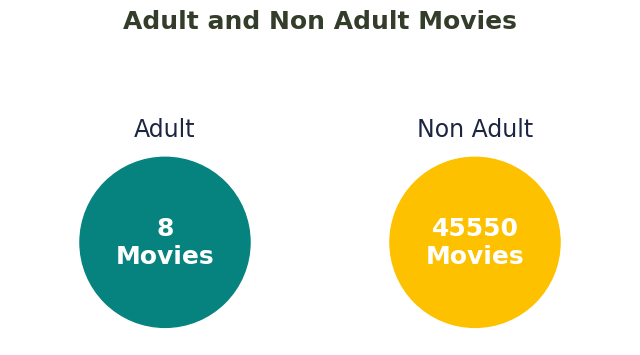

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

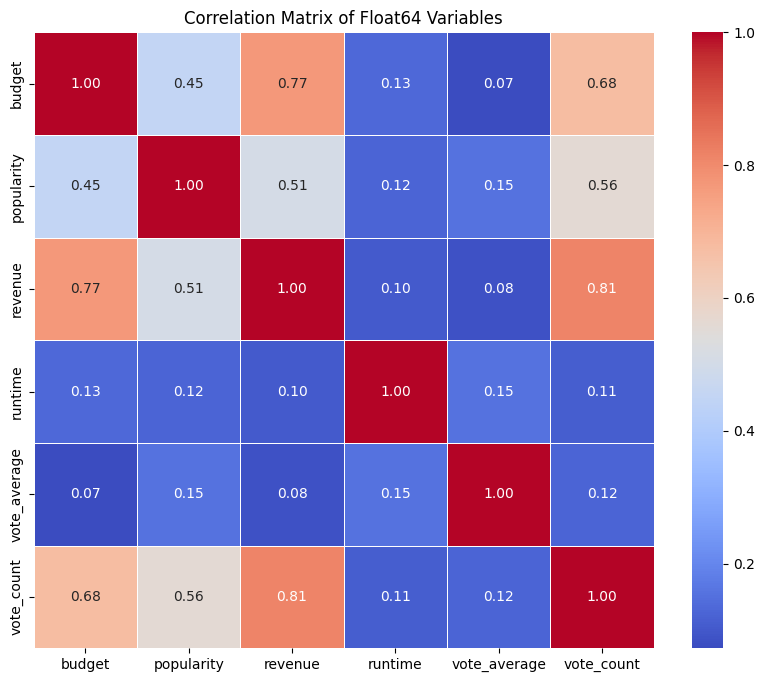

In [ ]:
# Select only columns of type float64
float_columns = df.select_dtypes(include=['float64'])

# Calculate the correlation matrix
correlation_matrix = float_columns.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set the title and display the plot
plt.title('Correlation Matrix of Float64 Variables')
plt.show()


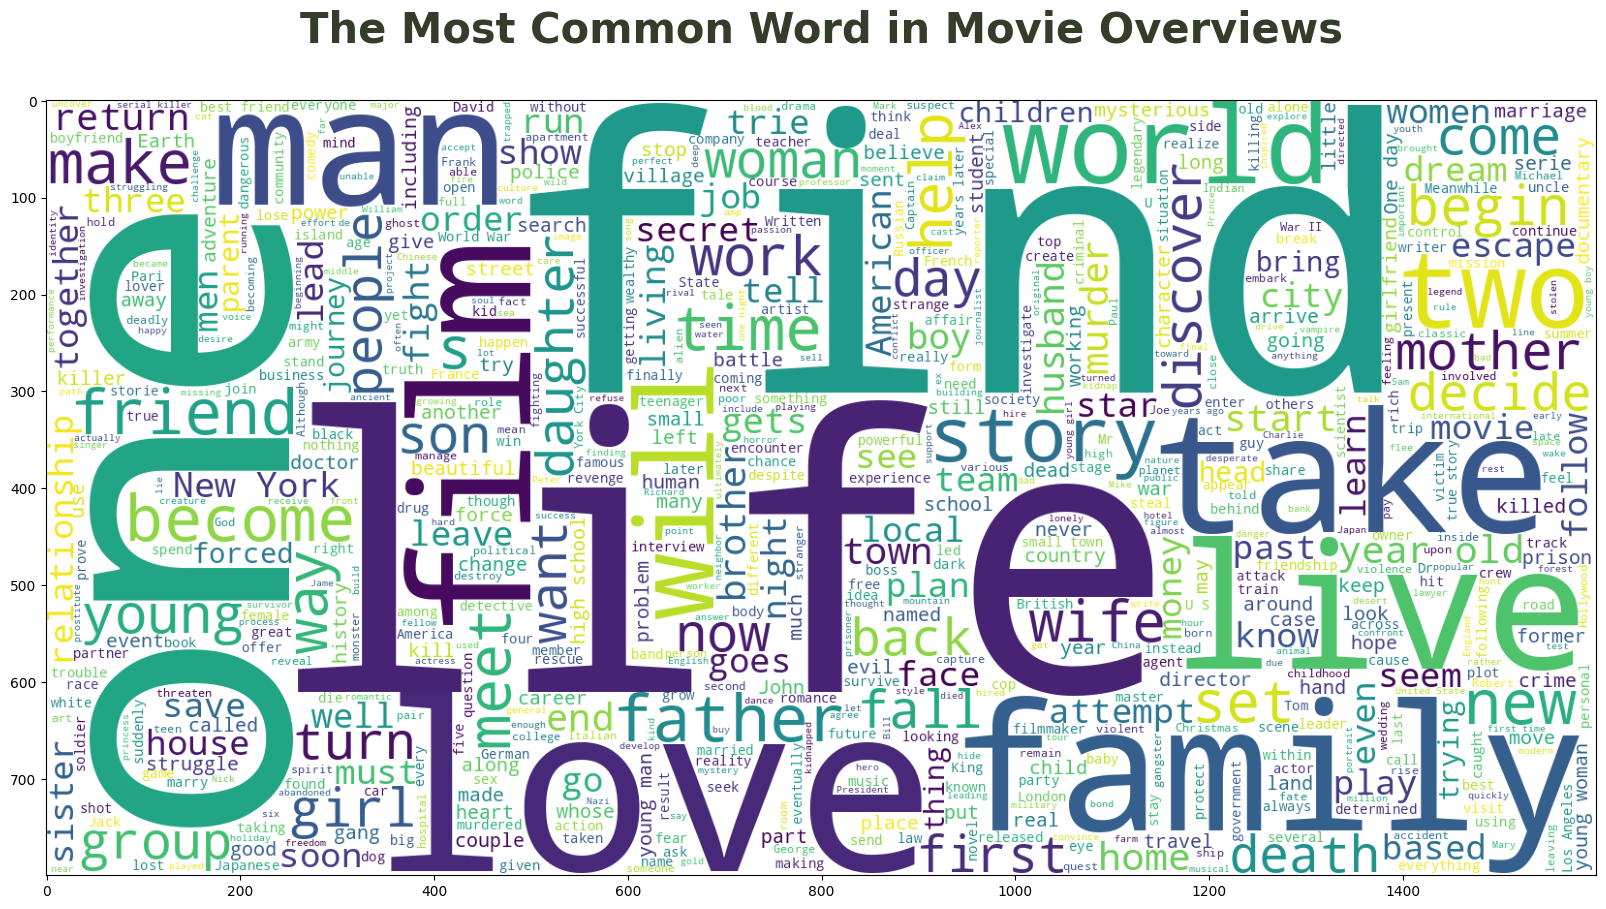

In [ ]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

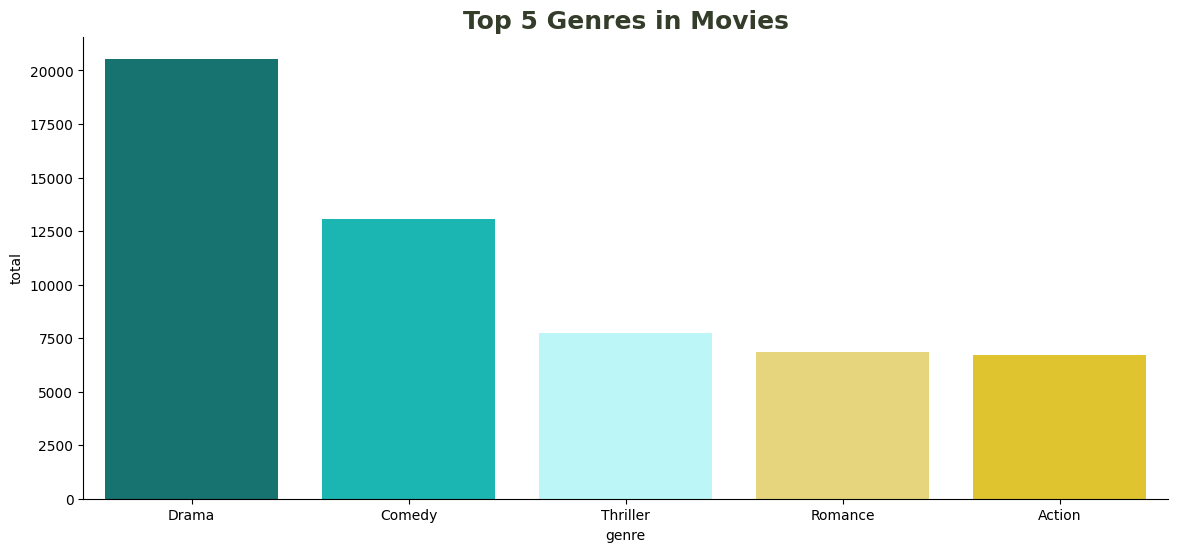

In [ ]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

**Recommender System**

*Content-Based*

In [ ]:
R = df['vote_average']
v = df['vote_count']
# We will only consider movies that have more votes than at least 60% of the movies in our dataset
m = df['vote_count'].quantile(0.6)
C = df['vote_average'].mean()

df['weighted_average'] = (R*v + C*m)/(v+m)

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

In [ ]:
weighted_df.head()

,popularity,weighted_average
original_title,,
Toy Story,0.040087,0.831038
Jumanji,0.031079,0.729052
Grumpier Old Men,0.021394,0.663805
Waiting to Exhale,0.007049,0.610309
Father of the Bride Part II,0.015320,0.576829


Prendiamo il **40% di peso per la media ponderata** e il **60% di peso per la popolarità**, considerando che le persone non vogliono perdersi un film di richiamo anche se le recensioni e le valutazioni sono scarse. Si può giocare con il numero. Successivamente, creiamo una nuova colonna chiamata punteggio che memorizza il risultato

In [ ]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [ ]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.666164,0.866465
Wonder Woman,0.537613,0.767597,0.629607
Beauty and the Beast,0.524675,0.716930,0.601577
Big Hero 6,0.390602,0.843823,0.571890
Baby Driver,0.416507,0.766768,0.556611
Guardians of the Galaxy Vol. 2,0.338511,0.818280,0.530419
Deadpool,0.343132,0.793325,0.523209
Pulp Fiction,0.257449,0.907467,0.517456
Gone Girl,0.282748,0.856478,0.512240


In [ ]:
content_df = df[['original_title', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'cast']]

In [ ]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [ ]:
content_df['genres'] = content_df['genres'].apply(remove_punc)
content_df['overview'] = content_df['overview'].apply(remove_punc)
content_df['production_companies'] = content_df['production_companies'].apply(separate)
content_df['tagline'] = content_df['tagline'].apply(remove_punc)
content_df['keywords'] = content_df['keywords'].apply(separate)
content_df['crew'] = content_df['crew'].apply(separate)
content_df['cast'] = content_df['cast'].apply(separate)

content_df['bag_of_words'] = ''
content_df['bag_of_words'] = content_df[content_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
content_df.set_index('original_title', inplace=True)

content_df = content_df[['bag_of_words']]
content_df.head()

,bag_of_words
original_title,
Toy Story,animation comedy family led by woody andys toy...
Jumanji,adventure fantasy family when siblings judy an...
Grumpier Old Men,romance comedy a family wedding reignites the ...
Waiting to Exhale,comedy drama romance cheated on mistreated and...
Father of the Bride Part II,comedy just when george banks has recovered fr...


In [ ]:
content_df = weighted_df_sorted[:10000].merge(content_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(content_df['bag_of_words'])
tfidf_matrix.shape

(12004, 24463)

In [ ]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(12004, 12004)

In [ ]:
content_df

,popularity,weighted_average,score,bag_of_words
original_title,,,,
'71,0.012933,0.699889,0.287715,thriller action drama war a young british sold...
(500) Days of Summer,0.029912,0.767198,0.324827,comedy drama romance tom joseph gordonlevitt g...
(Dis)Honesty: The Truth About Lies,0.002240,0.655722,0.263633,documentary a documentary about why people lie...
*batteries not included,0.020991,0.648421,0.271963,comedy family fantasy science fiction in a soo...
...And Justice for All,0.011492,0.734496,0.300693,crime drama mystery thriller an ethical baltim...
...,...,...,...,...
황해,0.008353,0.755532,0.307225,drama thriller crime the region where the bord...
회사원,0.011437,0.664490,0.272658,drama action hyeongdo so jisub is an assassin ...
１リットルの涙,0.001109,0.652927,0.261836,drama yearold ikeuchi aya was an ordinary girl...


In [ ]:
def predict(title, similarity_weight=0.7, top_n=10, similarity_threshold=0.1):
    data = content_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T

    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)

    # Refine the final score calculation to consider only movies with significant similarity
    final_df['final_score'] = final_df['score'] * (1 - similarity_weight) + final_df['similarity'] * similarity_weight

    # Apply a threshold for similarity score to filter out less similar movies
    final_df = final_df[final_df['similarity'] >= similarity_threshold]

    # Sort the DataFrame by final_score and select top N movies
    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)

    # Exclude highly similar movies or duplicates
    final_df_sorted.drop_duplicates(subset=['original_title'], keep='first', inplace=True)

    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [ ]:
predict('Jumanji', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Jumanji,0.310268,1.000000,0.793081
Mr. Holland's Opus,0.292428,0.127461,0.176951
October Sky,0.319830,0.106615,0.170580
Naked Lunch,0.301099,0.100402,0.160611
Class Action,0.261132,0.102673,0.150211


**Next Work**, search for generi (after when add Cheshire cat, I want add search for sentence)

In [ ]:
def predict_by_genre(genre, similarity_weight=0.7, top_n=10, similarity_threshold=0.1):
    # Filter content_df by genre
    genre_df = content_df[content_df['genres'].str.contains(genre, case=False)]

    data = genre_df.reset_index()

    # Calculate similarity between movies in the selected genre
    similarity = cosine_similarity(tfidf_matrix[data.index])

    sim_df = pd.DataFrame(similarity, columns=['similarity'], index=data.index)
    final_df = pd.concat([data, sim_df], axis=1)

    # Refine the final score calculation to consider only movies with significant similarity
    final_df['final_score'] = final_df['score'] * (1 - similarity_weight) + final_df['similarity'] * similarity_weight

    # Apply a threshold for similarity score to filter out less similar movies
    final_df = final_df[final_df['similarity'] >= similarity_threshold]

    # Sort the DataFrame by final_score and select top N movies
    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)

    # Exclude highly similar movies or duplicates
    final_df_sorted.drop_duplicates(subset=['original_title'], keep='first', inplace=True)

    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [ ]:
#predict_by_genre('Thriller', similarity_weight=0.7, top_n=10)

In [ ]:
# import pickle
# pickle.dump(tfidf_matrix, open('cosine_similarity.pkl', 'wb'))

**Deep Learning**

*Official documentation:* https://www.tensorflow.org/recommenders

In [ ]:
ratings_df = pd.read_csv('../input/ratings_small.csv')

ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,1,1371,2.5,2009-12-14 02:52:15,Rocky III,Drama,"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-14 02:53:23,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-14 02:52:19,American Pie,"Comedy, Romance","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-14 02:53:18,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-14 02:51:48,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...


In [ ]:
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [ ]:
ratings_df['userId'] = ratings_df['userId'].astype(str)

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

In [ ]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(25_875)
test = ratings.skip(25_875).take(19_000)

Total Data: 44875


In [ ]:
movie_titles = movies.batch(2_000)
user_ids = ratings.batch(2_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 42373
Unique users: 671


In [ ]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])

    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [ ]:
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(2_000).cache()
cached_test = test.batch(2_000).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
13/13 [==============================] - 139s 10s/step - root_mean_squared_error: 1.9248 - factorized_top_k/top_1_categorical_accuracy: 1.5459e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0030 - factorized_top_k/top_10_categorical_accuracy: 0.0081 - factorized_top_k/top_50_categorical_accuracy: 0.0620 - factorized_top_k/top_100_categorical_accuracy: 0.1137 - loss: 14943.2953 - regularization_loss: 0.0000e+00 - total_loss: 14943.2953
Epoch 2/3
13/13 [==============================] - 134s 10s/step - root_mean_squared_error: 1.1323 - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0165 - factorized_top_k/top_10_categorical_accuracy: 0.0371 - factorized_top_k/top_50_categorical_accuracy: 0.1723 - factorized_top_k/top_100_categorical_accuracy: 0.2873 - loss: 14266.8155 - regularization_loss: 0.0000e+00 - total_loss: 14266.8155
Epoch 3/3
13/13 [==============================] - 133s 10s/step - root_mean_squared_error: 1.

In [ ]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

10/10 [==============================] - 70s 6s/step - root_mean_squared_error: 0.9965 - factorized_top_k/top_1_categorical_accuracy: 8.4211e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0044 - factorized_top_k/top_10_categorical_accuracy: 0.0083 - factorized_top_k/top_50_categorical_accuracy: 0.0388 - factorized_top_k/top_100_categorical_accuracy: 0.0731 - loss: 13697.0431 - regularization_loss: 0.0000e+00 - total_loss: 13697.0431

Retrieval top-100 accuracy: 0.073
Ranking RMSE: 0.997


In [ ]:
# model.save_weights('tfrs.h5')

In [ ]:
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))

    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

In [ ]:
predict_movie(123, 5)

Top 5 recommendations for user 123:

1. Un long dimanche de fiançailles
2. The Greatest Story Ever Told
3. Dog Day Afternoon
4. 裸の島
5. Furankenshutain no Kaijū: Sanda tai Gaira


In [ ]:
predict_rating(123,'Minions')

Predicted rating for Minions: 3.1192917823791504
